In [1]:
using Revise
using TransportBasedInference
using HierarchicalDA
using LinearAlgebra
using OrdinaryDiffEq
using Trixi
using FFTW
using DifferentialEquations
using Distributions
using Statistics
using SparseArrays
using LinearMaps

In [2]:
using CairoMakie
using LaTeXStrings
# using Plots

In [3]:
polydeg = 3
Ncells = 100

Nx = (polydeg+1)*Ncells
Δ = 20
Ny = ceil(Int64, Nx/Δ)

# Define Trixi system for inviscid Burgers equation
sys_burgers = setup_burgers(polydeg, Ncells);

xgrid = vec(sys_burgers.mesh.md.xq);

Define polynomial annihilator operator

In [4]:
order_PA = 3

Ns = Nx - 2*ceil(Int64, order_PA/2)

PA = PolyAnnil(xgrid, order_PA; istruncated = true)

@assert size(PA.P) == (Ns, Nx)

S = LinearMaps.FunctionMap{Float64,true}((s,x)->mul!(s, PA.P, x), (x,s)->mul!(x, PA.P', s),
Ns, Nx; issymmetric=false, isposdef=false)

xs = xgrid[ceil(Int64, order_PA/2)+1:end-ceil(Int64, order_PA/2)]

396-element Vector{Float64}:
 -0.9866001895641519
 -0.9813886368840595
 -0.9786113631159403
 -0.9733998104358488
 -0.9666001895641518
 -0.9613886368840595
 -0.9586113631159403
 -0.9533998104358486
 -0.9466001895641517
 -0.9413886368840595
 -0.9386113631159403
 -0.9333998104358486
 -0.9266001895641518
  ⋮
  0.9333998104358489
  0.9386113631159406
  0.9413886368840593
  0.9466001895641516
  0.9533998104358488
  0.9586113631159405
  0.9613886368840594
  0.9666001895641515
  0.973399810435849
  0.9786113631159405
  0.9813886368840595
  0.9866001895641516

Define the time steps $\Delta t_{dyn}, \Delta t_{obs}$  of the dynamical and observation models. Observations from the truth are assimilated every $\Delta t_{obs}$.

In [5]:
Δtdyn = 0.002
Δtobs = 0.002

0.002

Define the time span of interest

In [6]:
t0 = 0.0
Tf = 400
Tspin = 200
tf = t0 + Tf*Δtobs

0.8

 Define the distribution for the initial condition $\pi_{\mathsf{X}_0}$

In [7]:
π0 = MvNormal(zeros(Nx), Matrix(1.0*I, Nx, Nx))

FullNormal(
dim: 400
μ: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Σ: [1.0 0.0 … 0.0 0.0; 0.0 1.0 … 0.0 0.0; … ; 0.0 0.0 … 1.0 0.0; 0.0 0.0 … 0.0 1.0]
)


In [8]:
σx_true = 1e-6#Δtobs*1.0
σx = 0.01#copy(σx_true)
@show σx


σy = 0.2

ϵx_true = AdditiveInflation(Nx, zeros(Nx), σx_true)
ϵx = AdditiveInflation(Nx, zeros(Nx), σx)

ϵy = AdditiveInflation(Ny, zeros(Ny), σy)

σx = 0.01


AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04000000000000001 0.0 … 0.0 0.0; 0.0 0.04000000000000001 … 0.0 0.0; … ; 0.0 0.0 … 0.04000000000000001 0.0; 0.0 0.0 … 0.0 0.04000000000000001], [0.2 0.0 … 0.0 0.0; 0.0 0.2 … 0.0 0.0; … ; 0.0 0.0 … 0.2 0.0; 0.0 0.0 … 0.0 0.2])

Setup system for inviscid Burgers equation

In [9]:
h(x, t) = x[1:Δ:end]
H = LinearMap(sparse(Matrix(1.0*I, Nx, Nx)[1:Δ:end,:]))
F = StateSpace(x->x, h)

StateSpace(var"#5#6"(), TransportBasedInference.var"#27#28"(), h)

Define ObsConstraintSystem

In [10]:
model = Model(Nx, Ny, Δtdyn, Δtobs, ϵx_true, ϵy, π0, 0, 0, 0, F);

In [11]:
# Define function class for the initial condition
αk = 0.7
f0 = SmoothPeriodic(xgrid, αk; L = 2.0)

SmoothPeriodic(400, 1, 2.0, 0.7, ComplexF64[-0.2830613546765043 + 0.04445817746913706im, 0.43677435035031953 - 0.6851115291005963im, -0.5678586412795467 - 0.07822624565156741im, -0.1307791400922782 - 0.24642173303104267im, 0.17407304523011785 - 0.018659251047831067im, 0.09941411908950071 - 0.18359479268635773im, 0.2173265806573273 - 0.20423305156762142im, 0.015493760877207689 + 0.2383566508378072im, 0.054383140006650184 + 0.0676971528668466im, -0.014825840300852109 - 0.03907806340184406im  …  9.929825794482066e-15 - 8.27409179452239e-15im, 7.378629803825541e-17 + 1.6447881697599324e-14im, -3.4332844684218313e-15 - 2.2228622182096754e-15im, -3.803512899068435e-15 + 4.681290827984664e-15im, -4.40933006590497e-15 + 1.224503301447806e-14im, -6.694946889413339e-16 - 1.451403128468677e-15im, 6.431149600892547e-15 + 5.009072475629459e-15im, -6.26701707560075e-15 - 3.6552241055055205e-15im, -8.024883795894332e-15 + 2.148444013209344e-15im, 2.8344761546510345e-16 - 3.582733734417097e-16im])

In [12]:
x0 = vec(1/2 .+ 0.5*sin.(3*π*sys_burgers.mesh.md.xq));
# x0 = f0.(xgrid);

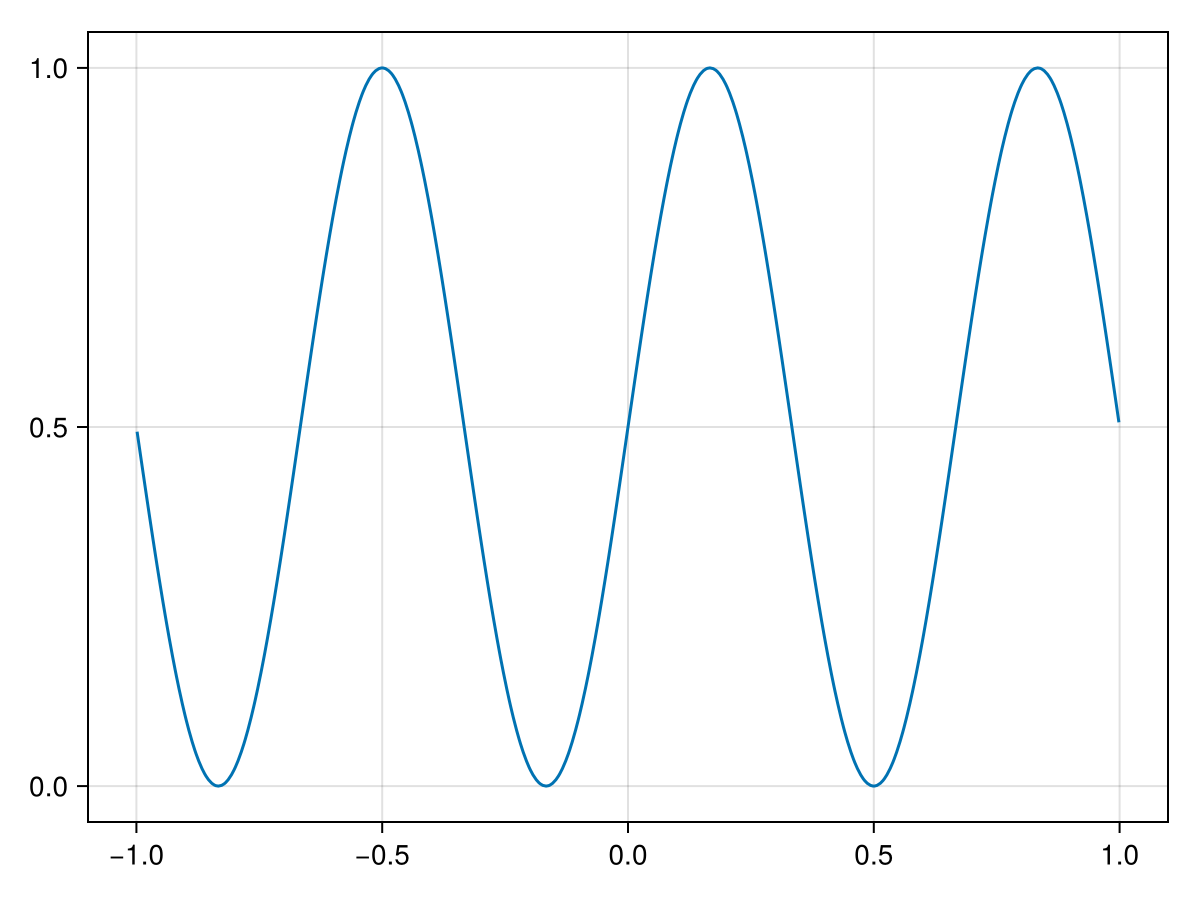

In [13]:
lines(xgrid, x0)

In [14]:
@time data = generate_data_trixi(model, x0, Tf, sys_burgers)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


 14.115268 seconds (38.55 M allocations: 2.371 GiB, 3.11% gc time, 98.52% compilation time)


SyntheticData([0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02  …  0.782, 0.784, 0.786, 0.788, 0.79, 0.792, 0.794, 0.796, 0.798, 0.8], 0.002, [0.4934563896573869, 0.4689173941833885, 0.4370225997681946, 0.4127450715138443, 0.39988966148727423, 0.3759585049420274, 0.34519359951990536, 0.3220375820269989, 0.3098693919682456, 0.2873938475030665  …  0.7126061524969327, 0.6901306080317535, 0.677962417973001, 0.6548064004800963, 0.6240414950579708, 0.6001103385127249, 0.5872549284861557, 0.5629774002318063, 0.5310826058166097, 0.5065436103426122], [0.4981491680588132 0.502933337907108 … 0.4364148556881961 0.4355538560546265; 0.4733722017211942 0.4779124480877485 … 0.4415630898239191 0.44069314697584167; … ; 0.5361248054894445 0.5412579892420069 … 0.42851054772448044 0.4276639271108425; 0.5113610614992097 0.5162726763780805 … 0.4336657749148835 0.4328089970122064], [0.438268742885917 0.44050065133072513 … 0.37983408032234856 0.14198698111564845; 0.04940323001

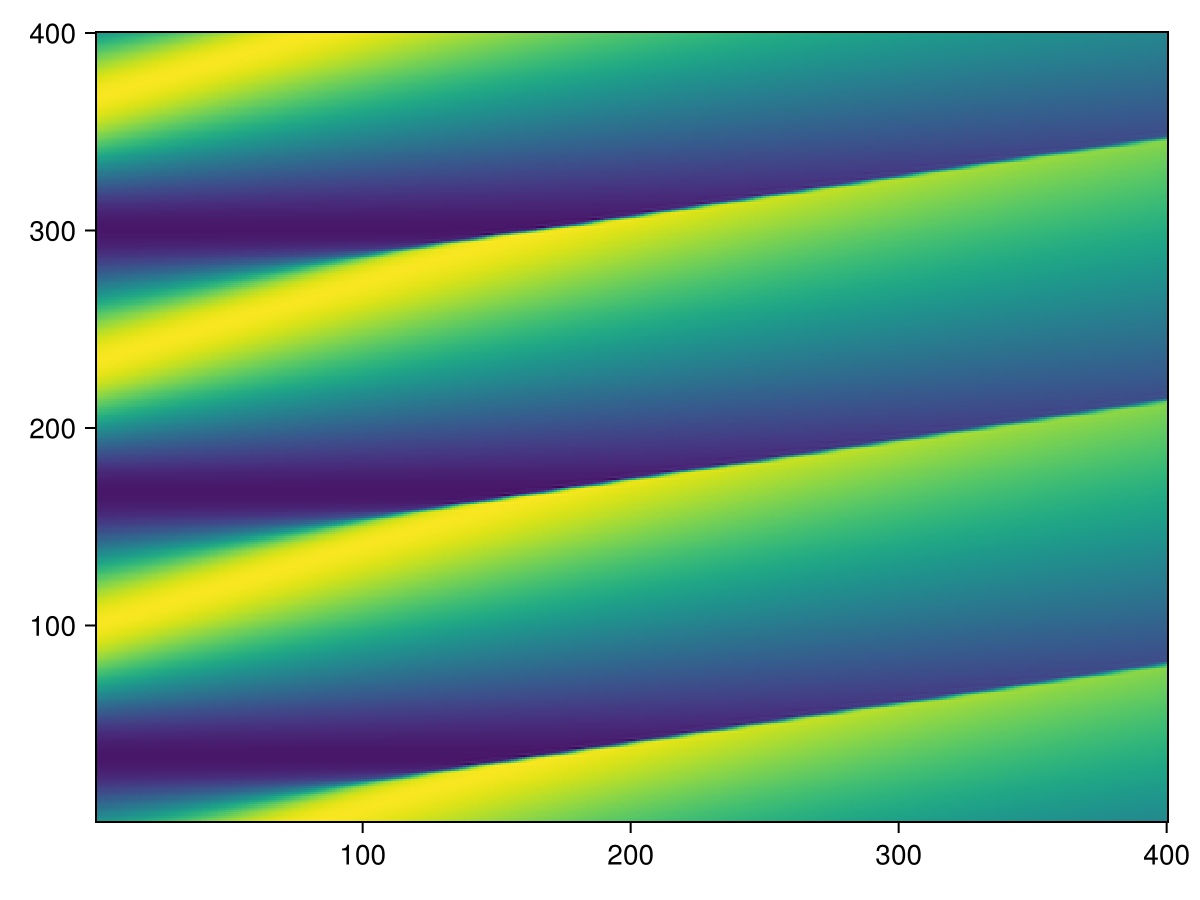

In [15]:
heatmap(data.xt[:, 1:end]')

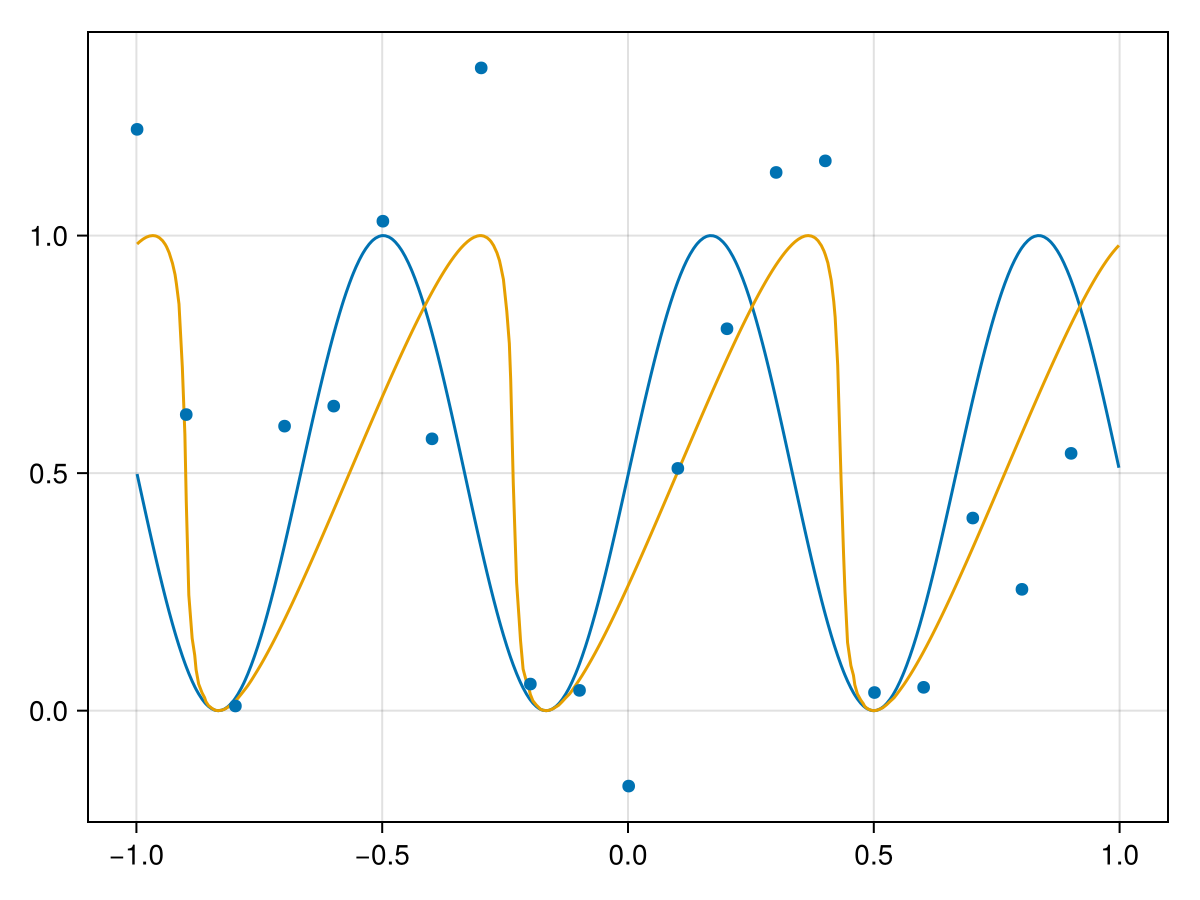

In [16]:
fig = Figure()
ax = Axis(fig[1,1])

lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xgrid, data.xt[:,100])
scatter!(ax, xgrid[1:Δ:end], data.yt[:,100])

fig

In [17]:
norm(data.xt[:,1] .- mean(data.xt[:,1]))

7.071073723066558

In [18]:
norm(data.xt[:,1000] .- mean(data.xt[:,1000]))

LoadError: BoundsError: attempt to access 400×400 Matrix{Float64} at index [1:400, 1000]

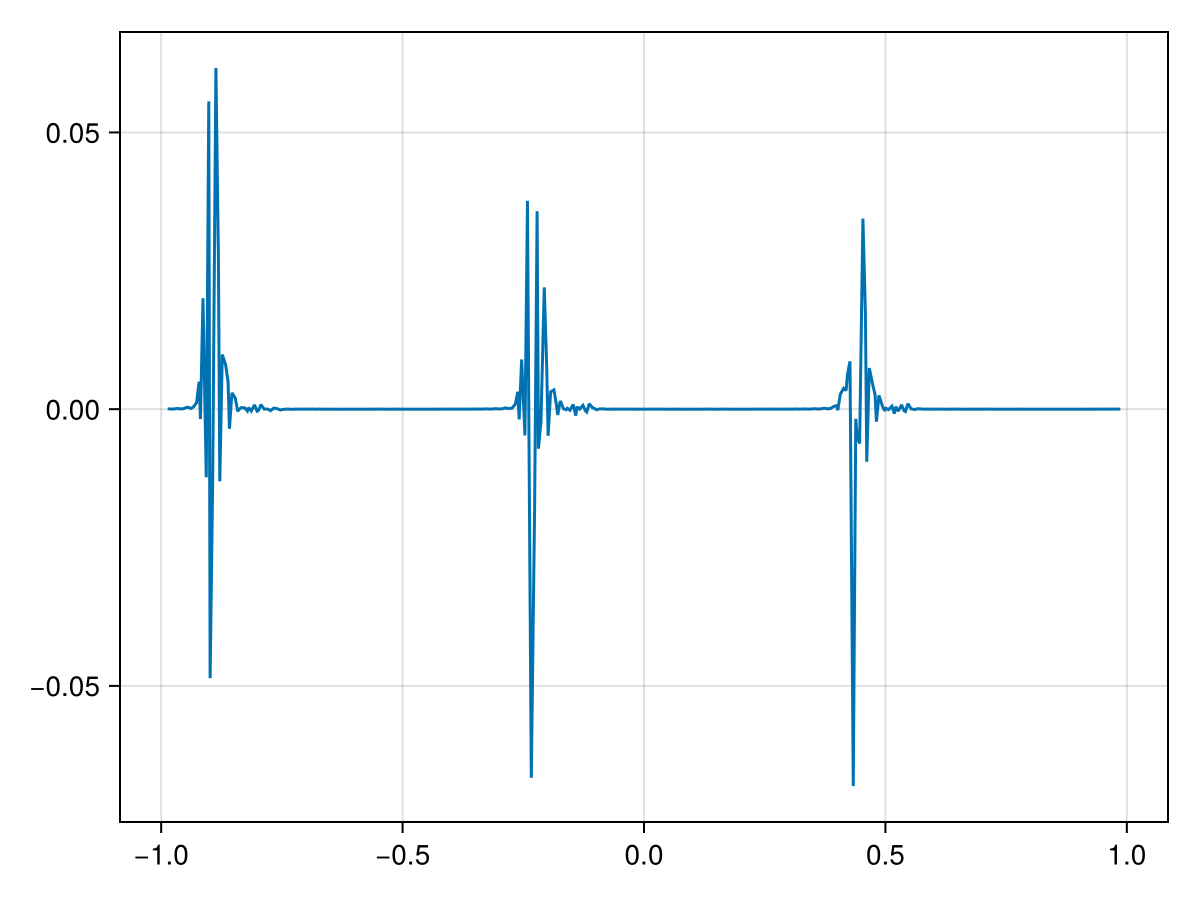

In [19]:
fig = Figure()
ax = Axis(fig[1,1])

# lines!(ax, xgrid, data.xt[:,1])
lines!(ax, xs, PA*data.xt[:,100])

fig

Define ObsConstraintSystem

In [20]:
idx = 4

## Selecion of hyper-prior parameters
# power parameter
r_range = [ 1.0, .5, -.5, -1.0 ]; 
r = r_range[idx] # select parameter 
# shape parameter
β_range = [ 1.501, 3.0918, 2.0165, 1.0017 ]; 
β = β_range[idx] # shape parameter
# rate parameters 
ϑ_range = [ 5*10^(-2), 5.9323*10^(-3), 1.2583*10^(-3), 1.2308*10^(-4) ]; 
ϑ = 5*10^(-3)#ϑ_range[idx]


# r = -0.5
# β = 0.5
# ϑ = 0.01
dist = GeneralizedGamma(r, β, ϑ);

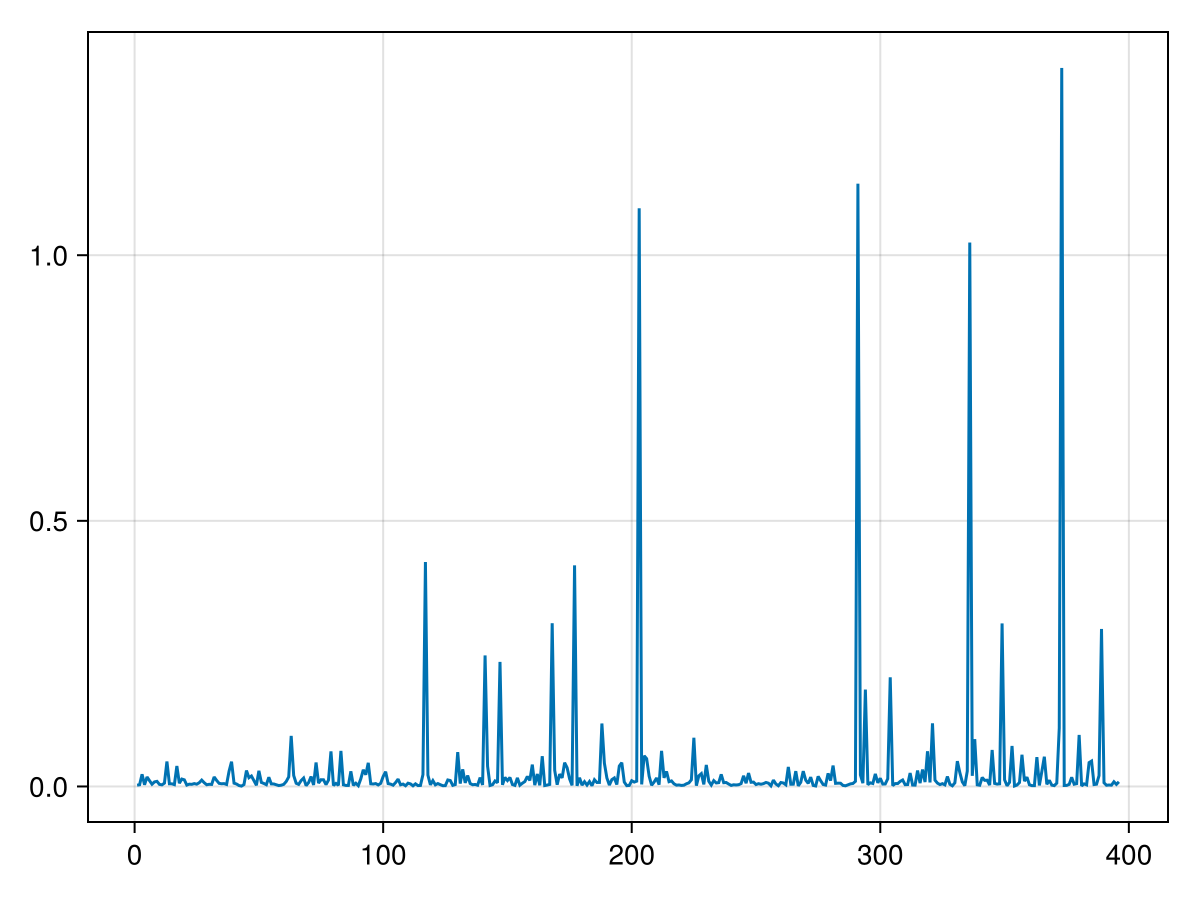

In [21]:
fig = Figure()

lines(rand(dist, Ns))

Create initial ensemble

In [22]:
Ne = 100
X = zeros(model.Ny + model.Nx, Ne)

for i=1:Ne
    regenerate!(f0)
    X[Ny+1:Ny+Nx,i] = f0.(xgrid)#initial_condition(αk, Δx, Nx)
end

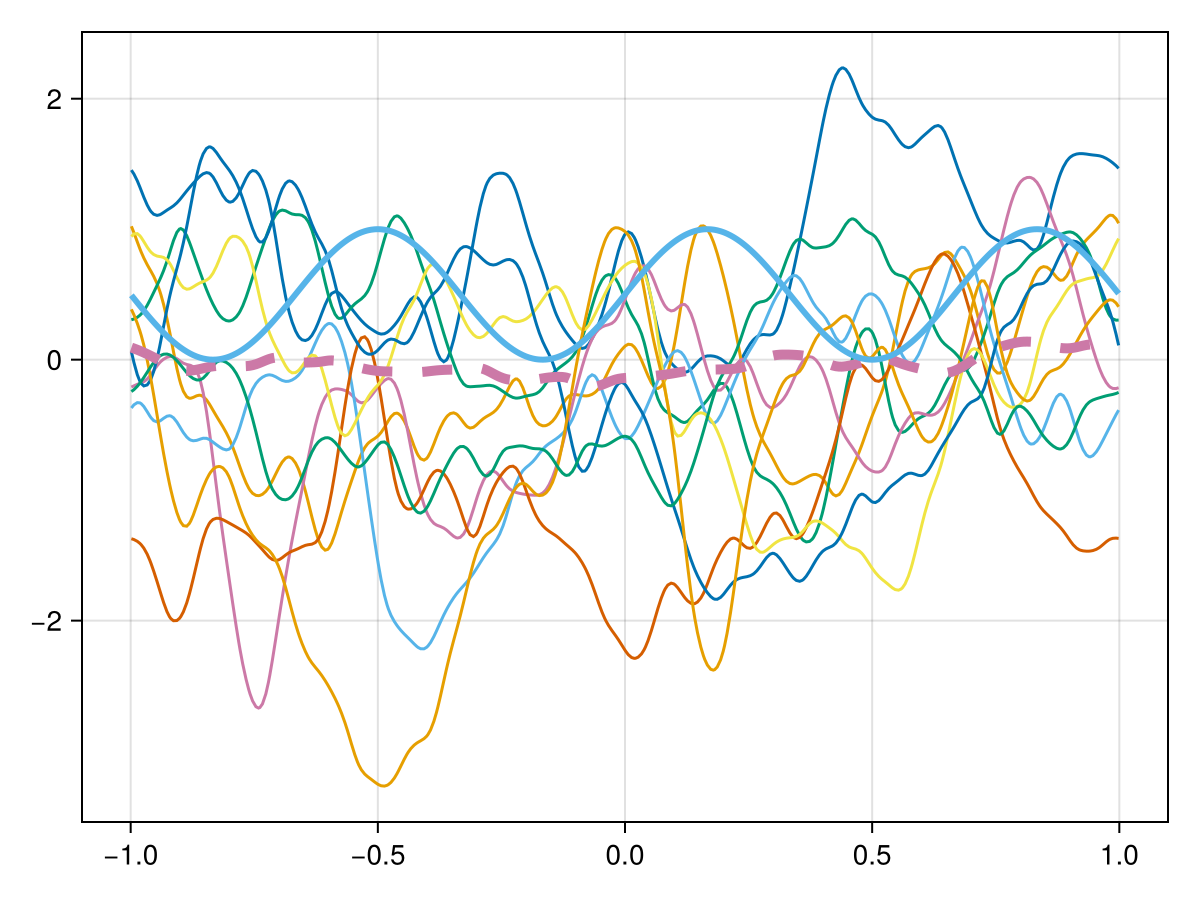

In [23]:
fig = Figure()

ax = Axis(fig[1,1])

for i=1:10
    lines!(ax, xgrid, X[Ny+1:Ny+Nx,i])
end
lines!(xgrid, mean(X[Ny+1:Ny+Nx,:]; dims = 2)[:,1], linewidth = 5, linestyle = :dash)

lines!(ax, xgrid, x0, linewidth = 3)

fig

Define initial guess

In [24]:
θinit = rand(dist, Ns);

Define linear maps and ObsConstraintSystem

In [25]:
Cθ = LinearMap(Diagonal(deepcopy(θinit)))
Cϵ = LinearMap(ϵy.Σ)
CX = LinearMap(Diagonal(1.0 .+ rand(Nx)))
sys_ys = ObsConstraintSystem(H, S, Cθ, Cϵ, CX)

ObsConstraintSystem(400, 20, 396, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 396×400 LinearMaps.FunctionMap{Float64,true}(#1, #2; issymmetric=false, ishermitian=false, isposdef=false), 396×396 LinearMaps.WrappedMap{Float64} of
  396×396 Diagonal{Float64, Vector{Float64}}, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [26]:
sys_y = ObsSystem(H, Cϵ, CX)

ObsSystem(400, 20, 20×400 LinearMaps.WrappedMap{Float64} of
  20×400 SparseMatrixCSC{Float64, Int64} with 20 stored entries, 20×20 LinearMaps.WrappedMap{Float64} of
  20×20 Diagonal{Float64, Vector{Float64}}, LinearMap[400×400 LinearMaps.WrappedMap{Float64} of
  400×400 Diagonal{Float64, Vector{Float64}}])

In [27]:
yidx = 1:Δ:Nx
idx = vcat(collect(1:length(yidx))', collect(yidx)')

# @assert length(yidx) == Ny

# # Create Localization structure
Gxx(i,j) = periodicmetric!(i,j, Nx)
Gxy(i,j) = periodicmetric!(i,yidx[j], Nx)
Gyy(i,j) = periodicmetric!(yidx[i],yidx[j], Nx)

Lrad = 7
Loc = Localization(Lrad, Gxx, Gxy, Gxx)

Localization(7.0, Gxx, Gxy, Gxx)

In [28]:
β = 1.01
ϵxβ = MultiAddInflation(Nx, β, zeros(Nx), σx)

MultiAddInflation(400, 1.01, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0001 0.0 … 0.0 0.0; 0.0 0.0001 … 0.0 0.0; … ; 0.0 0.0 … 0.0001 0.0; 0.0 0.0 … 0.0 0.0001], [0.01 0.0 … 0.0 0.0; 0.0 0.01 … 0.0 0.0; … ; 0.0 0.0 … 0.01 0.0; 0.0 0.0 … 0.0 0.01])

Define EnKF

In [29]:
enkf = EnKF(Ne, ϵy, sys_y, Δtdyn, Δtobs)

Ensemble Kalman filter with 
iterative solver = false and 
filtered = false


Define localized EnKF

In [30]:
locenkf = LocEnKF(Ne, ϵy, sys_y, Loc, Δtdyn, Δtobs)

Localized ensemble Kalman filter with iterative = false and filtered = false


Define hierarchical EnKF

In [31]:
henkf = HEnKF(Ne, ϵy, sys_ys, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical ensemble Kalman filter with
        iterative solver = false and
        filtered = false


Define hierarchical and localized EnKF

In [32]:
hlocenkf = HLocEnKF(Ne, ϵy, sys_ys, Loc, dist, deepcopy(θinit), Δtdyn, Δtobs)

Hierarchical localized ensemble Kalman filter with
        iterative solver = false and
        filtered = false


In [33]:
# X_enkf = seqassim_trixi(data, Tf, ϵxβ, enkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [34]:
X_locenkf = seqassim_trixi(data, Tf, ϵxβ, locenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


In [35]:
# X_henkf, θ_henkf = seqassim_trixi(data, Tf, ϵxβ, henkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

In [36]:
X_hlocenkf, θ_hlocenkf = seqassim_trixi(data, Tf, ϵxβ, hlocenkf, deepcopy(X), model.Ny, model.Nx, t0, sys_burgers);

Progress: 100%|█████████████████████████████████████████| Time: 0:12:48


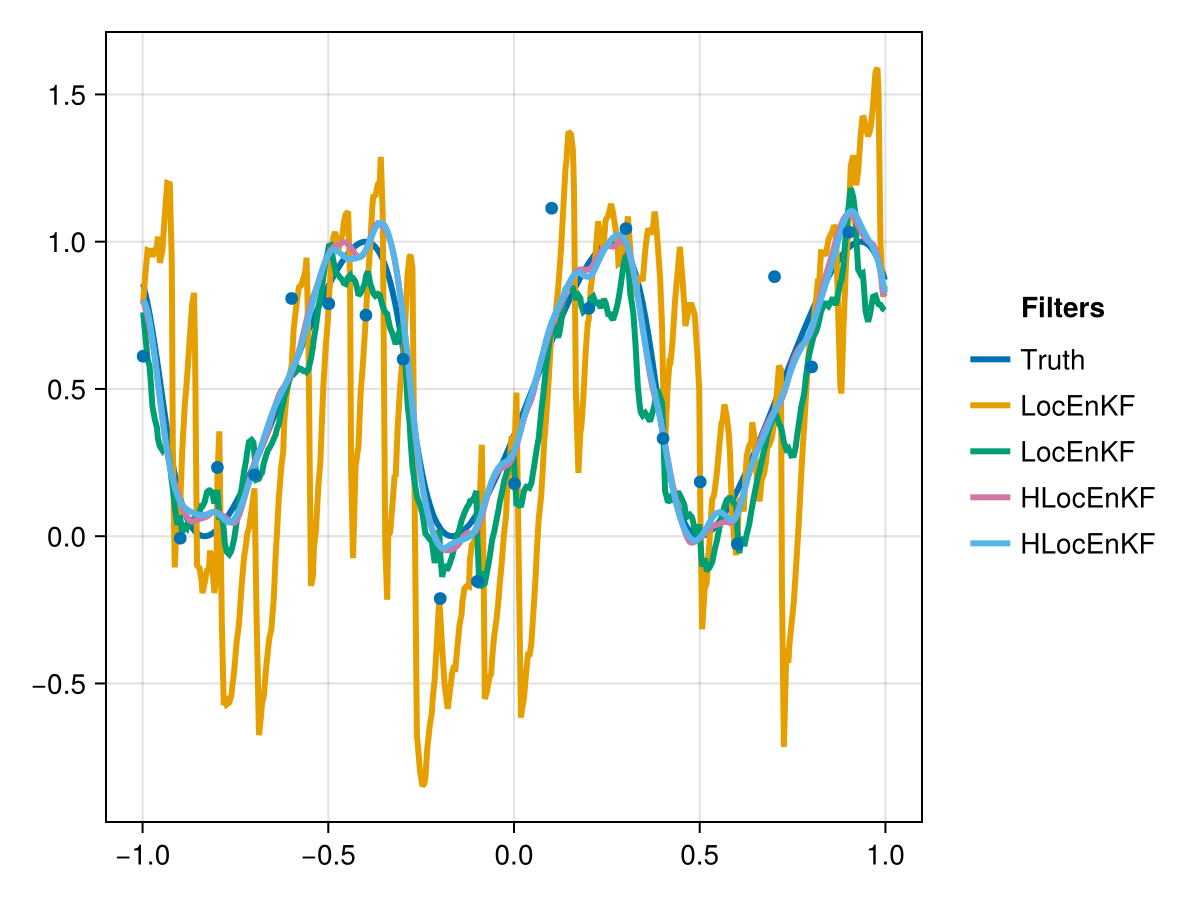

In [37]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 50
idx = 10

lines!(ax, xgrid, data.xt[:,tsnap], linewidth = 3, label = "Truth")

# lines!(ax, xgrid, X[Ny+1:Ny+Nx,2])
# lines!(ax, xgrid, X_enkf[tsnap+1][:,idx], linewidth = 3, label = "EnKF")
# lines!(ax, xgrid, mean(X_enkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "EnKF")

lines!(ax, xgrid, X_locenkf[tsnap+1][:,idx], linewidth = 3, label = "LocEnKF")
lines!(ax, xgrid, mean(X_locenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "LocEnKF")


# lines!(ax, xgrid, X_henkf[tsnap+1][:,2], linewidth = 3, label = "HEnKF")
# lines!(ax, xgrid, X_henkf[tsnap+1][:,2])
# lines!(ax, xgrid, mean(X_henkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HEnKF")

lines!(ax, xgrid, X_hlocenkf[tsnap+1][:,idx], linewidth = 3, label = "HLocEnKF")
lines!(ax, xgrid, mean(X_hlocenkf[tsnap+1]; dims = 2)[:,1], linewidth = 3, label = "HLocEnKF")

# ax2 = Axis(fig[1,2])

fig[1, 2] = Legend(fig, ax, "Filters", framevisible = false)

# lines!(ax, xgrid[1:2:end], data.yt[:,tsnap], linewidth = 3)


scatter!(ax, xgrid[1:Δ:end], data.yt[:,tsnap])
# lines!(ax, xs, PA.P*X_enkf[tsnap+1][:,2])


fig

In [38]:
rmse_locenkf = mean(map(i->norm(data.xt[:,i]-mean(X_locenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.12275631216763644

In [39]:
spread_locenkf = mean(map(i->spread(X_locenkf[i+1]), 1:Tf))

0.29655534695990304

In [40]:
crps_locenkf = mean(map(i->mean(map(k->CRPS(X_locenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), 1:Tf))

0.07200762573890243

In [41]:
rmse_hlocenkf = mean(map(i->norm(data.xt[:,i]-mean(X_hlocenkf[i+1]; dims = 2))/sqrt(Nx), 1:Tf))

0.06058412787329961

In [42]:
spread_hlocenkf = mean(map(i->spread(X_hlocenkf[i+1]), 1:Tf))

0.017680427343752473

In [43]:
crps_hlocenkf = mean(map(i->mean(map(k->CRPS(X_hlocenkf[i+1][k,:], data.xt[k,i]), 1:Nx)), 1:Tf))

0.03115158271588458

In [44]:
tsnap = Observable(1)

x_tsnap = @lift(hcat(data.x0, data.xt)[:,$(tsnap)])
y_tsnap = @lift(hcat(zeros(Ny), data.yt)[:,$(tsnap)])
X_locenkf_tsnap = @lift(mean(X_locenkf[$tsnap]; dims = 2)[:,1])
X_hlocenkf_tsnap = @lift(mean(X_hlocenkf[$tsnap]; dims = 2)[:,1])

scaled_θ_hlocenkf_tsnap = @lift(θ_hlocenkf[$tsnap] / norm(θ_hlocenkf[$tsnap]))


fig = Figure()

ax1 = Axis(fig[1,1])

lines!(ax1, xgrid, x_tsnap, linewidth = 3, label = "Truth")
lines!(ax1, xgrid, X_locenkf_tsnap, linewidth = 3, label = "LocEnKF")
lines!(ax1, xgrid, X_hlocenkf_tsnap, linewidth = 3, label = "HLocEnKF", linestyle =:dashdot)
scatter!(ax1, xgrid[1:Δ:end], y_tsnap, color = :grey)

axislegend(ax1)

ax2 = Axis(fig[1,2])

lines!(ax2, xs, scaled_θ_hlocenkf_tsnap, linewidth = 3, label = L"θ")
ylims!(ax2, 0.0, 0.6)

framerate = 10
timestamps = range(1, 101, step = 1)

record(fig, "inviscid_burgers.mp4", timestamps; framerate = framerate) do t
    tsnap[] = t
end

"inviscid_burgers.mp4"

In [45]:
time = Observable(0.0)

x1i = @lift(vcat(map(i->sim.u[i]($time)[1], 1:Ne)...))
x2i = @lift(vcat(map(i->sim.u[i]($time)[2], 1:Ne)...))

idx_color_tab = zeros(Int64, Ne)

for i=1:Ne
    x0i = sim.u[i](0.0)
    idx_color_tab[i] = ceil(Int64, phase_coloring(x0i, ColorSchemes.phase))
end


fig, axis, scatterplot = scatter(x1i, x2i, markersize = 20, color = ColorSchemes.phase[idx_color_tab], 
            fontsize = 20, 
            axis = (
            aspect = 1.0,
            title = @lift("t = $(round($time, digits = 1))"),
#             title =  @lift("t = $(time"),
            xlabel = L"x_1", 
            ylabel = L"x_2"))

CairoMakie.xlims!(axis, [-5.0, 5.0])
CairoMakie.ylims!(axis, [-5.0, 5.0])

framerate = 30
timestamps = range(0, tf, step=1/framerate)

record(fig, "spiral2D_animation.mp4", timestamps; framerate = framerate) do t
    time[] = t
end

LoadError: UndefVarError: `sim` not defined

In [46]:
mean(std(X_hlocenkf[50]; dims = 2))

0.016962605888332608

In [47]:
mean(std(X_locenkf[50]; dims = 2))

0.3898337192357119

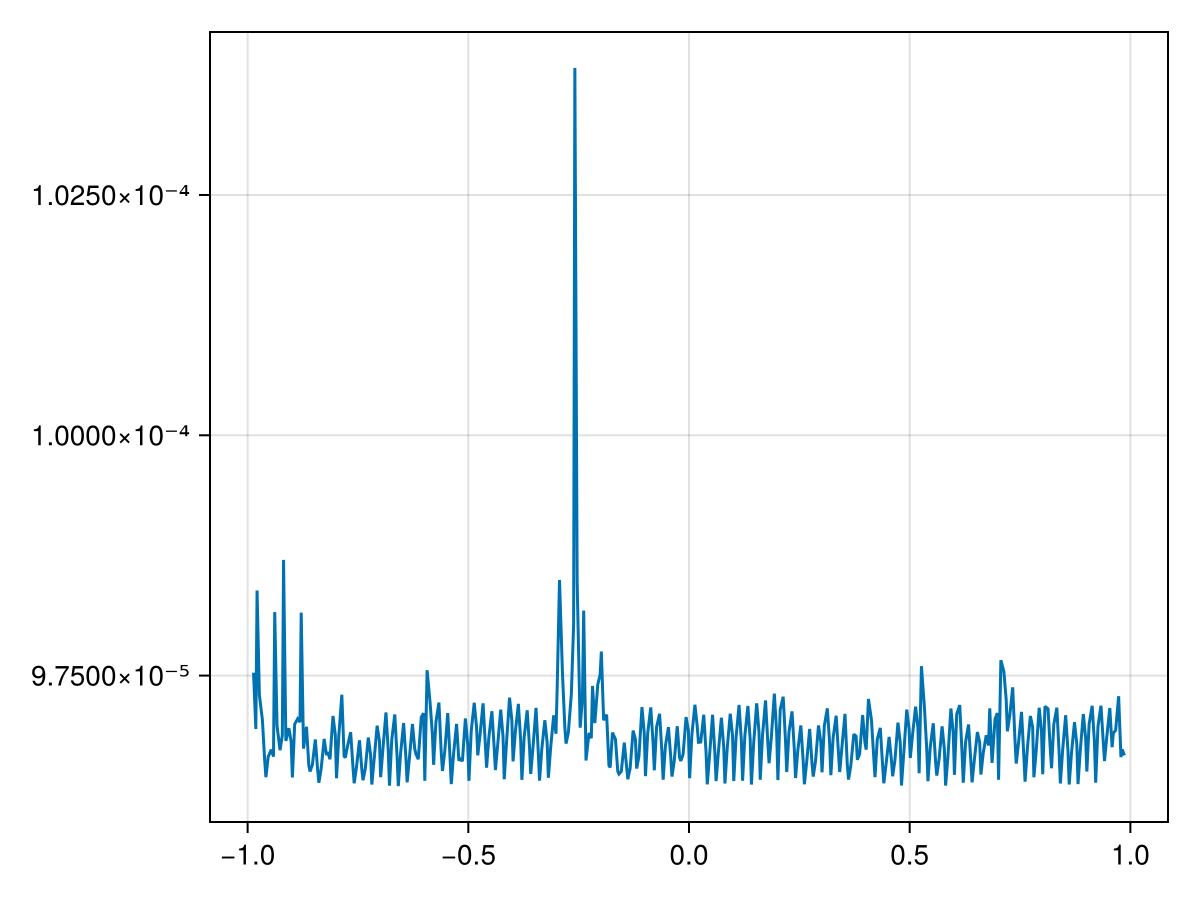

In [48]:
fig = Figure()

ax = Axis(fig[1,1])

tsnap = 80

# lines!(ax, xs, θ_henkf[tsnap])
lines!(ax, xs, θ_hlocenkf[tsnap])


fig